In [1]:
# @title Install required packages (run me) { display-mode: "form" }
# This may take a minute or two to complete.
%%capture
!pip install jaxlib
!pip install jax
!pip install git+https://github.com/deepmind/dm-haiku
!pip install gym==0.25
!pip install gym[box2d]
!pip install optax
!pip install matplotlib
!pip install chex

In [2]:
# @title Import required packages (run me) { display-mode: "form" }
%%capture
import copy
from shutil import rmtree # deleting directories
import random
import collections # useful data structures
import numpy as np
import gym # reinforcement learning environments
from gym.wrappers import RecordVideo
import jax
import jax.numpy as jnp # jax numpy
import haiku as hk # jax neural network library
import optax # jax optimizer library
import matplotlib.pyplot as plt # graph plotting library
from IPython.display import HTML
from base64 import b64encode
import chex

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create the environment
env_name = "CartPole-v0"
env = gym.make(env_name)

In [4]:
# Reset the environment
s_0 = env.reset()
print("Initial State::", s_0)

# Get environment obs space
obs_shape = env.observation_space.shape
print("Environment Obs Space Shape:", obs_shape)

Initial State:: [ 0.04090678 -0.02435194  0.04944371 -0.03584683]
Environment Obs Space Shape: (4,)


In [5]:
# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Environment action space: Discrete(2)
Number of actions: 2


In [6]:
# @title  Solution exercise 1 { display-mode: "form" }

def linear_policy(params, obs):
  """A simple linear policy

  Args:
    params: a vector of four real-numbers that give the parameters of the policy
    obs: a vector of four real-numbers that give the agent's observation

  Returns:
    a discrete action given by a 0 or 1
  """
  # YOUR CODE
  dot_product_result = jax.numpy.dot(params, obs)

  action = jax.lax.select(
      dot_product_result > 0, # boolean statement goes here
      1, # result when the statement is True goes here
      0, # result when the statement is False goes here
  )
  # END YOUR CODE
  return action

In [7]:
# @title Check exercise 1 (run me) { display-mode: "form" }

def check_linear_policy(linear_policy):
  fixed_obs = jnp.array([1,1,2,4])

  # check case1 - negative dot product.
  # weights
  params1 = jnp.array([1,1,1,1])
  params2 = jnp.array([-1,-1,-1,-1])

  hint1 = f"Incorrect answer, your linear policy is incorrect. The action when \
  obs={fixed_obs} and params={params1} should be 1"

  hint2 = f"Incorrect answer, your linear policy is incorrect. The action when \
  obs={fixed_obs} and params={params2} should be 0"

  hint = None
  if linear_policy(params1, fixed_obs) != 1:
    hint = hint1
  elif linear_policy(params2, fixed_obs) != 0:
    hint = hint2

  if hint is not None:
    print(hint)
  else:
    print("Your function is correct!")

try:
  check_linear_policy(linear_policy)
except Exception as e:
    print("An Error Occured: {}".format(e))

Your function is correct!


In [8]:
# Get the initial obs by resetting the env
initial_obs = env.reset()

# Randomly sample actions from env
action = env.action_space.sample()

# Step the environment
next_obs, reward, done, info = env.step(action)

print("Observation:", initial_obs)
print("Action:", action)
print("Next observation:", next_obs)
print("Reward:", reward)
print("Game is done:", done)

Observation: [-0.03103711  0.02935717 -0.02909264 -0.00151746]
Action: 0
Next observation: [-0.03044996 -0.16533573 -0.02912299  0.28184628]
Reward: 1.0
Game is done: False


In [9]:
def run_episode(env):
  episode_return = 0 # counter to keep track of rewards
  done = False # initially set to False
  params = jnp.array([1,-2,2,-1]) # fixed policy parameters

  ## YOUR CODE

  obs = env.reset() # TODO: get the initial obs from the env


  while not done: # loop until episode is done

    action = linear_policy(params, obs) # TODO: compute action using linear policy
    action = np.array(action) # We need to the convert the action from the policy to a np.array

    obs, reward, done, info = env.step(action) # TODO: step the environment


    episode_return = episode_return + reward # TODO: add reward to episode return

  return episode_return

In [11]:
# #@title Soluction Exercise 2 { display-mode: "form" }
# def run_episode(env):
#   episode_return = 0 # counter to keep track of rewards
#   done = False # initially set to False
#   params = jnp.array([1,-2,2,-1]) # fixed policy parameters

#   ## YOUR CODE

#   obs = env.reset() # TODO: get the initial obs from the env

#   while not done: # loop until episode is done

#     # HINT: You might need to the convert the action from your policy to a np.array
#     action = linear_policy(params, obs) # TODO: compute action using linear policy
#     action = np.array(action) # We need to the convert the action from the policy to a np.array

#     obs, reward, done, info = env.step(action) # TODO: step the environment

#     episode_return = episode_return + reward # TODO: add reward to episode return

#   return episode_return

In [10]:
# @title Check exercise 2 (run me) { display-mode: "form" }

try:
  env.seed(42)
  if run_episode(env) == 31:
    print("Looks correct!")
  else:
    print("Looks like your implementation might be wrong.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct!


In [12]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

# Training Loop
def run_training_loop(env_name, agent_params, agent_select_action_func,
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=100,
    evaluation_episodes=8, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):
    """
    This function runs several episodes in an environment and periodically does
    some agent learning and evaluation.

    Args:
        env: a gym environment.
        agent_params: an object to store parameters that the agent uses.
        agent_select_func: a function that does action selection for the agent.
        agent_actor_state (optional): an object that stores the internal state
            of the agents action selection function.
        agent_learn_func (optional): a function that does some learning for the
            agent by updating the agent parameters.
        agent_learn_state (optional): an object that stores the internal state
            of the agent learn function.
        agent_memory (optional): an object for storing an retrieving historical
            experience.
        num_episodes: how many episodes to run.
        evaluator_period: how often to run evaluation.
        evaluation_episodes: how many evaluation episodes to run.
        train_every_timestep: whether to train every timestep rather than at the end
            of the episode.
        video_subdir: subdirectory to store epsiode recordings.

    Returns:
        episode_returns: list of all the episode returns.
        evaluator_episode_returns: list of all the evaluator episode returns.
    """

    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array") # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array") # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    env.seed(0) # seed environment for reproducability
    random.seed(0)

    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()
        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, done, _ = env.step(int(action))

            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward, done, _ = eval_env.step(int(action))

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns

In [13]:
#@title Soluction Exercise 2 { display-mode: "form" }
def run_episode(env):
  episode_return = 0 # counter to keep track of rewards
  done = False # initially set to False
  params = jnp.array([1,-2,2,-1]) # fixed policy parameters

  ## YOUR CODE

  obs = env.reset() # TODO: get the initial obs from the env

  while not done: # loop until episode is done

    # HINT: You might need to the convert the action from your policy to a np.array
    action = linear_policy(params, obs) # TODO: compute action using linear policy
    action = np.array(action) # We need to the convert the action from the policy to a np.array

    obs, reward, done, info = env.step(action) # TODO: step the environment

    episode_return = episode_return + reward # TODO: add reward to episode return

  return episode_return

In [14]:
# @title Check exercise 2 (run me) { display-mode: "form" }

try:
  env.seed(42)
  if run_episode(env) == 31:
    print("Looks correct!")
  else:
    print("Looks like your implementation might be wrong.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct!


# **A General Purpose RL Training Loop**

In [15]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

# Training Loop
def run_training_loop(env_name, agent_params, agent_select_action_func,
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=100,
    evaluation_episodes=8, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):
    """
    This function runs several episodes in an environment and periodically does
    some agent learning and evaluation.

    Args:
        env: a gym environment.
        agent_params: an object to store parameters that the agent uses.
        agent_select_func: a function that does action selection for the agent.
        agent_actor_state (optional): an object that stores the internal state
            of the agents action selection function.
        agent_learn_func (optional): a function that does some learning for the
            agent by updating the agent parameters.
        agent_learn_state (optional): an object that stores the internal state
            of the agent learn function.
        agent_memory (optional): an object for storing an retrieving historical
            experience.
        num_episodes: how many episodes to run.
        evaluator_period: how often to run evaluation.
        evaluation_episodes: how many evaluation episodes to run.
        train_every_timestep: whether to train every timestep rather than at the end
            of the episode.
        video_subdir: subdirectory to store epsiode recordings.

    Returns:
        episode_returns: list of all the episode returns.
        evaluator_episode_returns: list of all the evaluator episode returns.
    """

    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array") # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array") # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    env.seed(0) # seed environment for reproducability
    random.seed(0)

    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()
        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, done, _ = env.step(int(action))

            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward, done, _ = eval_env.step(int(action))

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns

In [16]:
# Parameter container for Random Policy Search
RandomPolicySearchParams = collections.namedtuple("RandomPolicySearchParams", ["current", "best"])

# TEST: store two different sets of parameters
current_params = np.ones(obs_shape) * -1
best_params = np.zeros(obs_shape)
rps_params = RandomPolicySearchParams(current_params, best_params)

# How to access the best or current params.
print(f"Best params: {rps_params.best}")
print(f"Current params: {rps_params.current}")

Best params: [0. 0. 0. 0.]
Current params: [-1. -1. -1. -1.]


In [17]:
#@title Solution exercise 3 {display-mode: "form"}

def random_policy_search_choose_action(
    key,
    params,
    actor_state,
    obs,
    evaluation=False
):

  best_action = linear_policy(params.best, obs)

  current_action = linear_policy(params.current, obs)

  action = jax.lax.select(
      evaluation ,
      best_action ,
      current_action
  )

  return action, actor_state

In [18]:
# @title Check exercise 3 (run me) {display-mode: "form"}

def check_random_policy_search_choose_action(choose_action):
  key = None # not used
  actor_state = None # not used

  # obs
  obs = np.ones(obs_shape)

  evaluation=False
  current_params = np.ones(obs_shape) * -1
  best_params = np.ones(obs_shape)
  rps_params = RandomPolicySearchParams(current_params, best_params)
  action, actor_state = choose_action(key,rps_params,actor_state,obs,evaluation)
  if action != 0:
    return False

  evaluation=True
  current_params = np.ones(obs_shape) * -1
  best_params = np.ones(obs_shape)
  rps_params = RandomPolicySearchParams(current_params, best_params)
  action, actor_state = choose_action(key,rps_params,actor_state,obs,evaluation)
  if action != 1:
    return False

  return True

try:
  if check_random_policy_search_choose_action(random_policy_search_choose_action):
    print("Your function looks correct.")
  else:
    print("Your function looks incorrect.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Your function looks correct.


# **RPS agent memory**

# **Average Episode Return Memory**

In [19]:
class AverageEpisodeReturnBuffer:

    def __init__(self, num_episodes_to_store=50):
        """
        This class implements an agent memory that stores the average episode
        return over the last 50 episodes.
        """
        self.num_episodes_to_store = num_episodes_to_store
        self.episode_return_buffer = []
        self.current_episode_return = 0

    def push(self, transition):
        self.current_episode_return += transition.reward

        if transition.done: # If the episode is done
            # Add episode return to buffer
            self.episode_return_buffer.append(self.current_episode_return)

            # Reset episode return
            self.current_episode_return = 0


    def is_ready(self):
        return len(self.episode_return_buffer) == self.num_episodes_to_store

    def sample(self):
        average_episode_return = np.mean(self.episode_return_buffer)

        # Clear episode return buffer
        self.episode_return_buffer = []

        return average_episode_return

In [20]:
#@title Solution exercise 4 {display-mode: "form"}

def get_new_random_weights(random_key, old_weights,minval=-2.0,maxval=2.0):
    new_weights_shape = old_weights.shape
    new_weights_dtype = old_weights.dtype
    # Sample new weights
    new_weights = jax.random.uniform(random_key,new_weights_shape,new_weights_dtype,minval=minval,
                      maxval=maxval)
    return new_weights

In [21]:
# @title Check exercise 4 (run me) {display-mode: "form"}

def check_get_new_random_weights(get_new_random_weights):
  old_weights = np.ones(obs_shape, "float32")
  random_key = jax.random.PRNGKey(42)

  # Case 1
  new_weights = get_new_random_weights(random_key, old_weights, minval=-2.0, maxval=2.0)

  if jnp.array_equal(new_weights, jnp.array([ 0.29657745,1.4265499, -1.7621555, -1.7505779 ])):
    print("Function is correct!")
  else:
    print("Something is wrong.")

try:
  check_get_new_random_weights(get_new_random_weights)
except Exception as e:
    print("An Error Occured: {}".format(e))

Function is correct!


In [22]:
# A NamedTuple to store the best average episode return so far
RandomPolicyLearnState = collections.namedtuple(
  "RandomPolicyLearnState",
  ["best_average_episode_return"]
)

# Test
initial_learn_state = RandomPolicyLearnState(best_average_episode_return=-float("inf"))
print("Initial best average episode return:", initial_learn_state.best_average_episode_return)

Initial best average episode return: -inf


In [24]:
#@title Solution exercise 5 {display-mode: "form"}

def random_policy_search_learn(key, params, learn_state, memory):
    best_params = params.best
    current_params = params.current

    current_average_episode_return = memory # the memory contains the average episode return
    best_average_episode_return = learn_state.best_average_episode_return


    # YOUR CODE

    best_params = jax.lax.select(
        current_average_episode_return > best_average_episode_return,
        current_params,
        best_params,
    )

    best_average_episode_return = jax.lax.select(
        current_average_episode_return > best_average_episode_return,
        current_average_episode_return,
        best_average_episode_return
    )

    # END YOUR CODE

    # Generate new random parameters
    new_params = get_new_random_weights(key, current_params)

    # Bundle weights in RandomPolicySearchParams NamedTuple
    params = RandomPolicySearchParams(current=new_params, best=best_params)

    # Update learn_state
    learn_state = RandomPolicyLearnState(best_average_episode_return)

    return params, learn_state

In [25]:
#@title Check exercise 5 {display-mode: "form"}

params = RandomPolicySearchParams(np.ones(obs_shape, "float32"), np.ones(obs_shape, "float32") * -1)
learn_state = RandomPolicyLearnState(10)
memory = 11
key = jax.random.PRNGKey(42)

try:
  new_params, new_learn_state = random_policy_search_learn(key, params, learn_state, memory)

  if not jnp.array_equal(new_params.current, jnp.array([ 0.29657745,  1.4265499 , -1.7621555 , -1.7505779 ])):
    print("Your function is incorrect.")

  elif not jnp.array_equal(new_params.best, jnp.array([1., 1., 1., 1.])):
    print("Your function is incorrect.")

  elif new_learn_state.best_average_episode_return != 11:
    print("Your function is incorrect.")

  else:
    print("Your function looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Your function looks correct.


Starting training. This may take up to 5 minutes to complete.
Episode: 0	Episode Return: 80.0	Average Episode Return: 80.0	Evaluator Episode Return: 131.5
Episode: 100	Episode Return: 38.0	Average Episode Return: 10.55	Evaluator Episode Return: 130.75
Episode: 200	Episode Return: 9.0	Average Episode Return: 9.75	Evaluator Episode Return: 138.0
Episode: 300	Episode Return: 186.0	Average Episode Return: 17.9	Evaluator Episode Return: 121.0
Episode: 400	Episode Return: 9.0	Average Episode Return: 120.25	Evaluator Episode Return: 150.625
Episode: 500	Episode Return: 64.0	Average Episode Return: 11.9	Evaluator Episode Return: 128.0
Episode: 600	Episode Return: 126.0	Average Episode Return: 15.25	Evaluator Episode Return: 137.375
Episode: 700	Episode Return: 200.0	Average Episode Return: 44.15	Evaluator Episode Return: 154.0
Episode: 800	Episode Return: 200.0	Average Episode Return: 18.5	Evaluator Episode Return: 128.0
Episode: 900	Episode Return: 37.0	Average Episode Return: 10.75	Evaluator

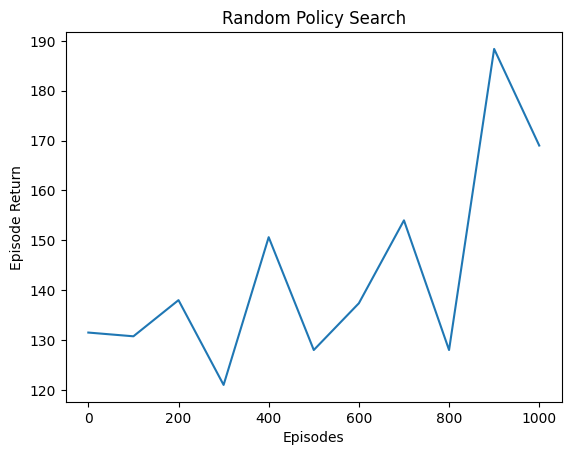

In [26]:
# JIT the learn and choose action functions
random_policy_search_learn_jit = jax.jit(random_policy_search_learn)
random_policy_search_choose_action_jit = jax.jit(random_policy_search_choose_action)

# Initialise the parameters
initial_weights = np.ones(obs_shape, "float32")
initial_params = RandomPolicySearchParams(initial_weights, initial_weights)

# Initialise the learn state
initial_learn_state = RandomPolicyLearnState(best_average_episode_return=-float("inf"))

# Initialise memory
memory = AverageEpisodeReturnBuffer(num_episodes_to_store=50)

# Run the training loop
print("Starting training. This may take up to 5 minutes to complete.")
chex.clear_trace_counter()
episode_return, evaluator_episode_returns = run_training_loop(
                                        env_name,
                                        initial_params,
                                        random_policy_search_choose_action_jit,
                                        None, # no actor state
                                        random_policy_search_learn_jit,
                                        initial_learn_state,
                                        memory,
                                        num_episodes=1001,
                                        video_subdir="rps"
                                    )

# Plot graph of evaluator episode returns
plt.plot(np.linspace(0, 1000, len(evaluator_episode_returns)), evaluator_episode_returns)
plt.title("Random Policy Search")
plt.xlabel("Episodes")
plt.ylabel("Episode Return")
plt.show()

In [27]:
#@title Visualise Policy {display-mode: "form"}
#@markdown Choose an episode number that is a multiple of 100 and less than or equal to 2000, and **run** this cell.
episode_number = 0 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 2000"

eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/rps/eval/rl-video-episode-{eval_episode_number}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

**Policy Gradients (PG)**

**REINFORCE**

In [28]:
# Solution exercise 6 {display-mode: "form"}

def compute_weighted_log_prob(action_prob, episode_return):

    # YOUR CODE

    log_prob = jax.numpy.log(action_prob)

    weighted_log_prob = log_prob * episode_return

    # END YOUR CODE

    return weighted_log_prob

In [29]:
#Check exercise 6 {display-mode: "form"}

try:
  action_prob = 0.8
  episode_return = 100
  result = compute_weighted_log_prob(action_prob, episode_return)
  if result != -22.314354:
    print("Your implementation looks incorrect.")
  else:
    print("Looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct.


# **Rewards-to-go**

In [30]:
# Solution exercise 7 {display-mode: "form"}

def compute_rewards_to_go(rewards):
    rewards_to_go = []
    for i in range(len(rewards)):
        r2g = 0
        for j in range(i, len(rewards)):
            r2g += rewards[j]
        rewards_to_go.append(r2g)
    return rewards_to_go

In [31]:
#@ Check exercise 7 {display-mode: "form"}

try:
  result = compute_rewards_to_go([1,2,3,4])

  if result != [10, 9, 7, 4]:
    print("There is a problem with your implementation.")
  else:
    print("Looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct.


In [32]:
#Solution exercise 7 {display-mode: "form"}

def compute_rewards_to_go(rewards):
    rewards_to_go = []
    for i in range(len(rewards)):
        r2g = 0
        for j in range(i, len(rewards)):
            r2g += rewards[j]
        rewards_to_go.append(r2g)
    return rewards_to_go

In [33]:
# Check exercise 7 {display-mode: "form"}

try:
  result = compute_rewards_to_go([1,2,3,4])

  if result != [10, 9, 7, 4]:
    print("There is a problem with your implementation.")
  else:
    print("Looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct.


# **REINFORCE memory**

In [34]:
# @title Memory implementation (run me) {display-mode: "form"}

# NamedTuple to store memory
EpisodeRewardsToGoMemory = collections.namedtuple("EpisodeRewardsToGoMemory", ["obs", "action", "reward_to_go"])

class EpisodeRewardsToGoBuffer:

    def __init__(self, num_transitions_to_store=512, batch_size=256):
        self.batch_size = batch_size
        self.memory_buffer = collections.deque(maxlen=num_transitions_to_store)
        self.current_episode_transition_buffer = []

    def push(self, transition):
        self.current_episode_transition_buffer.append(transition)

        if transition.done:

            episode_rewards = []
            for t in self.current_episode_transition_buffer:
                episode_rewards.append(t.reward)

            r2g = compute_rewards_to_go(episode_rewards)

            for i, t in enumerate(self.current_episode_transition_buffer):
                memory = EpisodeRewardsToGoMemory(t.obs, t.action, r2g[i])
                self.memory_buffer.append(memory)

            # Reset episode buffer
            self.current_episode_transition_buffer = []


    def is_ready(self):
        return len(self.memory_buffer) >= self.batch_size

    def sample(self):
        random_memory_sample = random.sample(self.memory_buffer, self.batch_size)

        obs_batch, action_batch, reward_to_go_batch = zip(*random_memory_sample)

        return EpisodeRewardsToGoMemory(
            np.stack(obs_batch).astype("float32"),
            np.asarray(action_batch).astype("int32"),
            np.asarray(reward_to_go_batch).astype("int32")
        )


# Instantiate Memory
REINFORCE_memory = EpisodeRewardsToGoBuffer(num_transitions_to_store=512, batch_size=256)

# **Policy neural network**

In [35]:
def make_policy_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for the policy."""

  def policy_network(obs):
    network = hk.Sequential(
        [
            hk.Flatten(),
            hk.nets.MLP(layers + [num_actions])
        ]
    )
    return network(obs)

  return hk.without_apply_rng(hk.transform(policy_network))

In [36]:
# Example
POLICY_NETWORK = make_policy_network(num_actions=num_actions, layers=[20,20])
random_key = jax.random.PRNGKey(42) # random key
dummy_obs = np.ones(obs_shape, "float32")

# Initialise parameters
REINFORCE_params = POLICY_NETWORK.init(random_key, dummy_obs)
print("Initial params:", REINFORCE_params.keys())

# Pass input through the network
output = POLICY_NETWORK.apply(REINFORCE_params, dummy_obs)
print("Policy network output:", output)

Initial params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])
Policy network output: [ 0.91155875 -0.39617383]


# **REINFORCE choose action function**

In [37]:
# Solution exercise 8 {display-mode: "form"}

def sample_action(random_key, logits):

    # YOUR CODE HERE

    action = jax.random.categorical(random_key, logits)

    # END YOUR code

    return action

In [39]:
# Check exercise 8 {display-mode: "form"}

try:
  random_key = jax.random.PRNGKey(42) # random key
  action = sample_action(random_key, np.array([1,2], "float32"))
  if action != 1:
    print("Your function is incorrect.")
  else:
    print("Seems correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Seems correct.


In [40]:
def REINFORCE_choose_action(key, params, actor_state, obs, evaluation=False):
  obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim before passing through network

  # Pass obs through policy network to compute logits
  logits = POLICY_NETWORK.apply(params, obs)
  logits = logits[0] # remove batch dim

  # Randomly sample action
  sampled_action = sample_action(key, logits)

  return sampled_action, actor_state

# **Policy gradient loss**

In [43]:
#Solution exercise 9 {display-mode: "form"}

def policy_gradient_loss(action, logits, reward_to_go):

  # YOUR CODE

  all_action_probs = jax.nn.softmax(logits) # convert logits into probs

  action_prob = all_action_probs[action]

  weighted_log_prob = compute_weighted_log_prob(action_prob, reward_to_go)

  # END YOUR CODE

  loss = - weighted_log_prob # negative because we want gradient `ascent`

  return loss

In [44]:
#Check exercise 9 {display-mode: "form"}

try:
  result = policy_gradient_loss(1, np.array([1,2], "float32"), 10)
  if result != 3.1326165:
    print("Your implementation looks wrong.")
  else:
    print("Looks correct.")
except Exception as e:
  print("An Error Occured: {}".format(e))

Your implementation looks wrong.


In [45]:
def batched_policy_gradient_loss(params, obs_batch, action_batch, reward_to_go_batch):
    # Get logits by passing observation through network
    logits_batch = POLICY_NETWORK.apply(params, obs_batch)

    policy_gradient_loss_batch = jax.vmap(policy_gradient_loss)(action_batch, logits_batch, reward_to_go_batch) # add batch

    # Compute mean loss over batch
    mean_policy_gradient_loss = jnp.mean(policy_gradient_loss_batch)

    return mean_policy_gradient_loss

# TEST
obs_batch = np.ones((3, *obs_shape), "float32")
actions_batch = np.array([1,0,0])
rew2go_batch = np.array([2.3, 4.3, 2.1])

loss = batched_policy_gradient_loss(REINFORCE_params, obs_batch, actions_batch, rew2go_batch)

print("Policy gradient loss on batch:", loss)

Policy gradient loss on batch: 1.6967316


In [46]:
REINFORCE_OPTIMIZER = optax.adam(1e-3)

# Initialise the optimiser
REINFORCE_optim_state = REINFORCE_OPTIMIZER.init(REINFORCE_params)

In [47]:
# A NamedTuple to store the state of the optimiser
REINFORCELearnState = collections.namedtuple("LearnerState", ["optim_state"])


def REINFORCE_learn(key, params, learner_state, memory):

  # Get the policy gradient by using `jax.grad()` on `batched_policy_gradient_loss`
  grad_loss = jax.grad(batched_policy_gradient_loss)(params, memory.obs, memory.action, memory.reward_to_go)

  # Get param updates using gradient and optimizer
  updates, new_optim_state = REINFORCE_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply updates to params
  params = optax.apply_updates(params, updates)

  return params, REINFORCELearnState(new_optim_state) # update learner state

# **REINFORCE training loop**

In [ ]:
# JIT the choose_action and learn functions for more speed
REINFORCE_learn_jit = jax.jit(REINFORCE_learn)
REINFORCE_choose_action_jit = jax.jit(REINFORCE_choose_action)

# Initial learn state
REINFORCE_learn_state = REINFORCELearnState(REINFORCE_optim_state)

# Run training loop
print("Starting training. This may take up to 10 minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        REINFORCE_params,
                                        REINFORCE_choose_action_jit,
                                        None, # action state not used
                                        REINFORCE_learn_jit,
                                        REINFORCE_learn_state,
                                        REINFORCE_memory,
                                        num_episodes=10_001,
                                        learn_steps_per_episode=2,
                                        video_subdir="reinforce"
                                      )

# Plot the episode returns
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("REINFORCE")
plt.show()

Starting training. This may take up to 10 minutes to complete.
Episode: 0	Episode Return: 12.0	Average Episode Return: 12.0	Evaluator Episode Return: 18.625
Episode: 100	Episode Return: 48.0	Average Episode Return: 86.2	Evaluator Episode Return: 103.375
Episode: 200	Episode Return: 182.0	Average Episode Return: 140.85	Evaluator Episode Return: 147.25
Episode: 300	Episode Return: 180.0	Average Episode Return: 180.05	Evaluator Episode Return: 199.625
Episode: 400	Episode Return: 200.0	Average Episode Return: 151.8	Evaluator Episode Return: 159.0
Episode: 500	Episode Return: 200.0	Average Episode Return: 194.25	Evaluator Episode Return: 195.375
Episode: 600	Episode Return: 200.0	Average Episode Return: 195.8	Evaluator Episode Return: 185.125
Episode: 700	Episode Return: 139.0	Average Episode Return: 196.95	Evaluator Episode Return: 192.5
Episode: 800	Episode Return: 200.0	Average Episode Return: 200.0	Evaluator Episode Return: 200.0
Episode: 900	Episode Return: 177.0	Average Episode Retur

In [ ]:
#Visualise Policy {display-mode: "form"}
#Choose an episode number that is a multiple of 100 and less than or equal to 1000, and **run this cell**.

episode_number = 100 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 1000"

eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/reinforce/eval/rl-video-episode-{eval_episode_number}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# **Q-Learning**

Another common aproach to finding an optimal policy in an environment using RL is via Q-learning.

# **State-Action Value function**

**Greedy action selection**

In [ ]:
# Solution exercise 10 {display-mode: "form"}

def select_greedy_action(q_values):

  # YOUR CODE
  action = jnp.argmax(q_values)
  # END YOUR CODE

  return action

In [ ]:
#  Check exercise 10 (run me) {display-mode: "form"}

try:
  q_values = jnp.array([1,1,3,4])
  action = select_greedy_action(q_values)

  if action != 3:
    print("Incorrect answer, your greedy action selector looks wrong")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))

# **Q-Network**

In [ ]:
def build_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for approximating Q-values."""

  def q_network(obs):
    network = hk.Sequential(
        [hk.Flatten(),
         hk.nets.MLP(layers + [num_actions])])
    return network(obs)

  return hk.without_apply_rng(hk.transform(q_network))

In [ ]:
# Initialise Q-network
Q_NETWORK = build_network(num_actions=num_actions, layers=[20, 20]) # two actions

dummy_obs = jnp.zeros((1,*obs_shape), jnp.float32) # a dummy observation like the one in CartPole

random_key = jax.random.PRNGKey(42) # random key
Q_NETWORK_PARAMS = Q_NETWORK.init(random_key, dummy_obs) # Get initial params

print("Q-Learning params:", Q_NETWORK_PARAMS.keys())

# **The Bellman Equations**

# **The Bellman Backup**

In [ ]:
#Solution exercise 11 {display-mode: "form"}
def compute_squared_error(pred, target):

  # YOUR CODE
  squared_error = jax.numpy.square(pred - target)
  # END YOUR CODE
  return squared_error

In [ ]:
#Check exercise 11 {display-mode: "form"}

try:
  result = compute_squared_error(1, 4)

  if result != 9:
    print("Your implementation looks wrong.")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))

In [ ]:
# Solution exercise 12 {display-mode: "form"}

# Bellman target
def compute_bellman_target(reward, done, next_q_values):
    """A function to compute the bellman target.

    Args:
        reward: a scalar reward.
        done: a scalar of value either 1.0 or 0.0, indicating if the transition is a terminal one.
        next_q_values: a vector of q_values for the next state. One for each action.
    Returns:
        A scalar equal to the bellman target.

    """
    # YOUR CODE
    bellman_target = reward + (1.0 - done) * jax.numpy.max(next_q_values)
    # END YOUR CODE

    return bellman_target

In [ ]:
#Check exercise 12 {display-mode: "form"}

try:
  # not done
  result1 = compute_bellman_target(1, 0.0, np.array([3,2], "float32"))

  # done
  result2 = compute_bellman_target(1, 1.0, np.array([3,2], "float32"))

  if result1 != 4 or result2 != 1:
    print("Your implementation looks wrong.")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))